In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from pandas import DataFrame, Series
from numpy import nan as NA
import time
import sys

In [2]:
data=pd.read_table("data1.txt",header=None)

In [3]:
data[0]

0    -0.462713
1    -0.417415
2     0.539800
3     0.209401
4    -0.331078
5     0.018611
6     0.410988
7     0.163732
8     0.108133
9     0.911623
10   -0.347408
11   -0.188066
12    0.944166
13   -0.456991
14   -1.539136
15    0.214494
16    0.287334
17   -0.088734
18    0.069308
19    0.376213
20    0.619901
21   -0.336850
22   -0.070439
23   -0.048640
24   -0.170147
25    0.785026
26    1.380423
27    1.465365
28    1.210325
29    0.315033
        ...   
70   -0.663449
71   -0.360256
72    0.092664
73   -1.248298
74   -0.119284
75   -0.220043
76   -0.080750
77   -0.064396
78   -0.481312
79    0.513795
80   -0.200719
81    0.010751
82    1.403881
83   -0.026556
84    0.370723
85    0.074012
86    0.172732
87   -0.190826
88    0.256713
89    0.186311
90   -0.230645
91    0.061279
92    0.690074
93    0.706873
94    0.234140
95    1.323630
96    0.241479
97    0.470188
98    0.888042
99    1.069386
Name: 0, dtype: float64

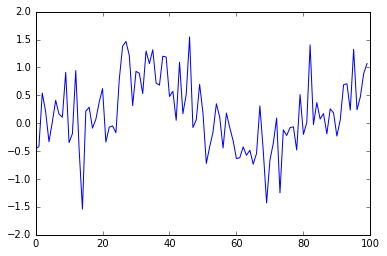

In [4]:
plt.plot(data)

パーティクルフィルターにおける固定ラグ平滑化の本質は、フィルターをかけた際（t|t）にリサンプリングされたサンプルと同じインデックスについて(t-1|t),(t-2|t),...,(t-lag|t)をサンプリングし直すこと。

In [18]:
def trend_and_seasonal_model(y, num, lag, sigma2, alpha_mu2, alpha_s2):
        
#########################################################
# Setting & Initialization
########################################################

    #Settings
    T=len(y)
    index=np.arange(0,num)
    
    #Initialization
    x_t_given_t=[np.random.normal(0, 2, size=num*8).reshape(num, 8)]
    
    log_p=[]
    

######################################################
# sub routine
######################################################
    #observation model
    def observation_model(y, x_t_given_t_minus_1,sigma2):
        H=np.array([1,0,1,0,0,0,0,0])
        return sp.stats.norm.pdf(y,np.dot(H,x_t_given_t_minus_1.T),sigma2**0.5)
    
    #system model
    def system_model(x_t_minus_1, v_t):
        #linear gauss state space model
        F=np.array([[2,-1,0,0,0,0,0,0],
                    [1,0,0,0,0,0,0,0],
                    [0,0,-1,-1,-1,-1,-1,-1],
                    [0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0],
                    [0,0,0,0,1,0,0,0],
                    [0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,1,0]])
        G=np.array([[1,0],
                    [0,0],
                    [0,1],
                    [0,0],
                    [0,0],
                    [0,0],
                    [0,0],
                    [0,0]])
        
        return (np.dot(F, x_t_minus_1.T) + np.dot(G, v_t.T)).T
    

#################################################
# implimentation
#################################################

    for t in xrange(T):
        
        #system noise
        mu_v = [0,0]
        Q_v = [[sigma2*alpha_mu2, 0],
             [0, sigma2+alpha_s2]]
        v_t=sp.stats.multivariate_normal.rvs(mu_v, Q_v, size=num)
        
        #predict
        x_t_given_t_minus_1 = system_model(x_t_given_t[t], v_t)

        #calculate weights for filtering
        w_t=observation_model(y[t], x_t_given_t_minus_1, sigma2)
        
        #resumpling    
        current_index=np.random.choice(a=index,p=w_t/np.sum(w_t),size=num)
        x_t_given_t_temp = x_t_given_t
        if t <= lag:
            #filter
            x_t_given_t.append(x_t_given_t_minus_1[current_index])

            #update paste state by lag width = lag
            for j in xrange(t+1):
                x_t_given_t[t-j] = x_t_given_t_temp[t-j][current_index]
        else:
            #filter
            x_t_given_t.append(x_t_given_t_minus_1[current_index])

            #update paste state by lag width = lag
            for j in xrange(lag+1):
                x_t_given_t[t-j] = x_t_given_t_temp[t-j][current_index]
            
        log_p.append(np.log(np.mean(w_t)))
            
    return [np.array(x_t_given_t), np.sum(log_p)]
        

In [19]:
start = time.time ()
sys.stdout.write("Start" + "\n")
    
result=[]
log_likelihood=-10000000

ite=0
for i in range(10):
    for j in range(10):
        for k in range(10):
            sigma2=2**(i-8)
            alpha_mu2=10**(j-8)
            alpha_s2=10**(k-8)
            
            result=trend_and_seasonal_model(data[0], 1000, 10, sigma2, alpha_mu2, alpha_s2)
            
            if log_likelihood < result[1]:
                log_likelihood = result[1]
                best_result = result
                
            ite+=1
            sys.stdout.write("\r" + str (1.*ite/(10*10*10)*100) + "%," +  "  Time : " + str ( time.time() - start ))
            sys.stdout.flush ()

Start
100.0%,  Time : 171.744999886

In [20]:
log_likelihood

-117.51473301763667

In [21]:
mu=[]
s=[]
for t in range(len(best_result[0])):
    mu.append(np.mean(np.array(best_result[0][t])[:,0]))
    s.append(np.mean(np.array(best_result[0][t])[:,2]))

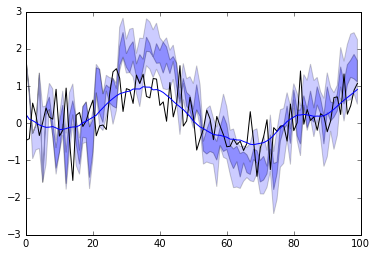

In [22]:
t=np.arange(0,len(data[0]))
percentile_2_5=[]
percentile_25=[]
percentile_50=[]
percentile_75=[]
percentile_97_5=[]
for i in range(len(data[0])):
    draws=np.sum(best_result[0][i], axis=1)[1:]
    percentile_2_5.append(np.percentile(draws,2.5))
    percentile_25.append(np.percentile(draws,25))
    percentile_50.append(np.percentile(draws,50))
    percentile_75.append(np.percentile(draws,75))
    percentile_97_5.append(np.percentile(draws,97.5))

x = np.concatenate((t,t[::-1]))
y_50 = np.concatenate((percentile_25,percentile_75[::-1]))
y_95 = np.concatenate((percentile_2_5,percentile_97_5[::-1]))

p_50 = plt.fill(x, y_50, facecolor='b', alpha=0.3)
p_95 = plt.fill(x, y_95, facecolor='b', alpha=0.2)

plt.plot(data[0],color="black")
plt.plot(mu[1:])

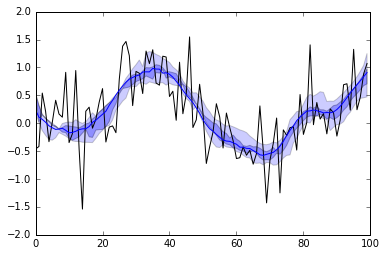

In [23]:
t=np.arange(0,len(data[0]))
percentile_2_5=[]
percentile_25=[]
percentile_50=[]
percentile_75=[]
percentile_97_5=[]
for i in range(len(data[0])):
    percentile_2_5.append(np.percentile(np.array(best_result[0][i])[1:,0],2.5))
    percentile_25.append(np.percentile(np.array(best_result[0][i])[1:,0],25))
    percentile_50.append(np.percentile(np.array(best_result[0][i])[1:,0],50))
    percentile_75.append(np.percentile(np.array(best_result[0][i])[1:,0],75))
    percentile_97_5.append(np.percentile(np.array(best_result[0][i])[1:,0],97.5))

x = np.concatenate((t,t[::-1]))
y_50 = np.concatenate((percentile_25,percentile_75[::-1]))
y_95 = np.concatenate((percentile_2_5,percentile_97_5[::-1]))

p_50 = plt.fill(x, y_50, facecolor='b', alpha=0.3)
p_95 = plt.fill(x, y_95, facecolor='b', alpha=0.2)

plt.plot(data[0],color="black")
plt.plot(mu[1:])

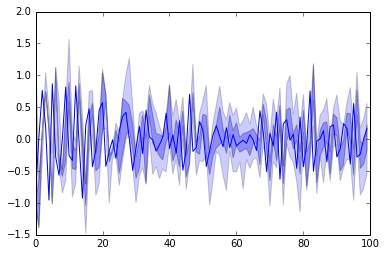

In [24]:
t=np.arange(0,len(data[0]))
percentile_2_5_s=[]
percentile_25_s=[]
percentile_50_s=[]
percentile_75_s=[]
percentile_97_5_s=[]
for i in range(len(data[0])):
    percentile_2_5_s.append(np.percentile(np.array(best_result[0][i])[1:,2],2.5))
    percentile_25_s.append(np.percentile(np.array(best_result[0][i])[1:,2],25))
    percentile_50_s.append(np.percentile(np.array(best_result[0][i])[1:,2],50))
    percentile_75_s.append(np.percentile(np.array(best_result[0][i])[1:,2],75))
    percentile_97_5_s.append(np.percentile(np.array(best_result[0][i])[1:,2],97.5))

x = np.concatenate((t,t[::-1]))
y_50_s = np.concatenate((percentile_25_s,percentile_75_s[::-1]))
y_95_s = np.concatenate((percentile_2_5_s,percentile_97_5_s[::-1]))

p_50_s = plt.fill(x, y_50_s, facecolor='b', alpha=0.3)
p_95_s = plt.fill(x, y_95_s, facecolor='b', alpha=0.2)

plt.plot(s[1:])